---
format:
  html:
    other-links:
      - text: This notebook
        href: A8.ipynb
---

# A8: Solving Poisson's equation in 1d

- Complete the following and submit to Canvas before Nov 24 9AM,
- Late work will recieve 0%,
- Each assignment is worth the same, 
- Please get in contact with the instructor in plenty of time if you need help,
- Before submitting your work, make sure to check everything runs as expected. Click **Kernel > Restart Kernel and Run All Cells**.
- Feel free to add more cells to experiment or test your answers,
- I encourage you to discuss the course material and assignment questions with your classmates. You may complete this assignment in groups of at most 2 - please clearly state who you are working with,
- The use of GenAI is prohibited as outlined in the course syllabus. If I suspect you of cheating, you may be asked to complete a written or oral exam on the content of this assignment. 

In [4]:
# | code-fold: true

using Plots
using LaTeXStrings
using Polynomials
using LinearAlgebra

"""
    ChebyshevNodes( n; type=2) 

Returns the ``n+1`` Chebyshev nodes ``X = \\{x_0, ..., x_n\\}`` of type type (default being type II) 
"""
function ChebyshevNodes( n; type=2) 
    if (type == 1)
        return @. cos( (2*(n:-1:0)+1)*pi/(2*(n+1)) )
    else
        return @. cos( (pi/n)*(n:-1:0) )
    end
end

"""
    ChebyshevInterpolant( f, n ) 

Returns the polynomial of degree ``n`` interpolating ``f`` at Chebyshev nodes using the Barycentric formula
"""
function ChebyshevInterpolant( f, n ) 
    x = ChebyshevNodes(n)
    y = f.(x)

    λ = zeros(n+1)
    λ[1] = 1/2
    λ[n+1] = (-1)^n/2
    for j in 1:(n-1)
        λ[j+1] = (-1)^j
    end

    return t -> t in x ? f(t) : sum( @. λ * y / (t - x) ) / sum( @. λ / (t - x) )
end

"""
    Lagrange( f, n ) 

"""
function Lagrange( i, n ) 
    x = ChebyshevNodes(n)
    y = [ j==i ? 1 : 0 for j=0:n ]

    return fit( ChebyshevT, x, y )
end

mesh = -1:0.001:1;

For a fixed *forcing* $f:[-1,1] \to \mathbb R$, we consider *Poisson's equation with Direchlet boundary conditions*:

\begin{align}
    -u''(x) &= f(x) \\
    u(-1) &= u_- \\
    u(+1) &= u_+.
\end{align}

(Poisson's equation in dimension $d$ is given by $- \Delta u := - \sum_{i=1}^d \frac{\partial^2u}{\partial x_i^2} = f$. Here, $\Delta$ is the Laplacian and $-\Delta u = 0$ is known as Laplace's equation.)

This equation appears in different areas of applied math and engineering. For example, 

* Heat conduction: $u$ models the equilibrium temperature on a rod $[-1,1]$ given internal sources of heat $f$, 
* Electrostatics: $u$ is the electricstatic potential given a charge density $f$, 
* Elastic deformation: $u$ is the displacement of a beam under external forces $f$,
* Newton's law of gravitation, ....

The boundary condition states that the e.g. temperature at the edge of the rod is fixed and equal to $u_{\pm}$.

In the following questions we will solve this boundary value problem numerically in the case that $u_- = u_+ = 0$:

1. Suppose that $\{\phi_{j}\}_{j=1}^{n-1}$ is a set of functions satisfying the boundary conditions $\phi_j(-1) = \phi_j(1) = 0$. Show that $u(x) = \sum_{j=1}^{n-1} c_j \phi_j(x)$ satisfies the boundary conditions $u(-1) = u(1) = 0$ for any choice of coefficients $\{c_j\}$.

<div class='alert alert-block alert-success'><b>Answer.</b> 

[Your answer here]

</div> 

2. Show that if we assume $u = \sum_{j=1}^{n-1} c_j \phi_j$ solves the differential equation $-u'' = f$, then 

\begin{align}
    \sum_{j=1}^{n-1} \int_{-1}^1 \phi_i'(x) \phi_j'(x) \mathrm{d}x \,\, c_j 
    %
    &= \int_{-1}^1 \phi_i(x)  f(x) \mathrm{d}x 
\end{align}

for all $i = 1,2, \dots, n-1$. Hint: multiply $-u'' = f$ by $\phi_i$ and integrate (this is known as a *weak formulation* of the problem). 

<div class='alert alert-block alert-success'><b>Answer.</b> 


</div> 

Notice that this equation can be written as $A \bm c = \bm b$ with 

\begin{align}
    A_{ij} &:= \int_{-1}^{+1} \phi_i'(x) \phi_j'(x) \mathrm{d}x \\
    %
    b_i &:= \int_{-1}^{+1} \phi_i(x) f(x) \mathrm{d}x.
\end{align}

We may therefore approximate the solution of Poisson's equation by solving $A \bm c = \bm b$ (e.g. by using Julia's built in LU decomposition algorithm ```A \ b```) and expanding $u(x) = \sum_{j=1}^{n-1} c_j \phi_j(x)$. 

In the following, we consider Poisson's equation with forcing $f(x) = -x$.

3. Show that the function $u(x) = \frac{1}{6} x(x^2-1)$ solves the boundary value problem $-u''(x) = -x$ with $u(-1) = u(+1) = 0$. 

<div class='alert alert-block alert-success'><b>Answer.</b> 


</div>

In general, a closed form expression for the solution is unavaliable and one has to implement numerical schemes to find the solution. In this case, we choose an example that we can compute analytically so that we can analyse the errors in our approximation schemes. 

Therefore, all that is left to do is choose a basis $\{ \phi_j \}$ and solve the system $A \bm c = \bm b$. Notice that the Poisson equation  may be well-conditioned, but our choice of implementation (our basis $\{\phi_j\}$) may be unstable (as we will now see).

### Lagrange polynomials

Fix a set of distinct nodes $X = \{x_0, \dots, x_n\}$ with $x_0 = -1$ and $x_n = +1$ and recall that the Lagrange polynomial $\ell_j$ is the degree $n$ polynomial such that $\ell_j(x_j) = 1$ and $\ell_j(x_i) = 0$ for all $i\not= j$. Notice that for all $j = 1,\dots,n-1$ we have $\ell_j(-1) = \ell_j(+1) = 0$ and so the approximation $u(x) = \sum_{j=1}^{n-1} c_j \ell_j(x)$ satisfies the boundary conditions. 

Here, we construct $A$ and $\bm b$ and solve $A \bm c = \bm b$ numerically using this basis set with $X$ the set of Chebyshev nodes:

error in max norm = 2.983724378680108e-16


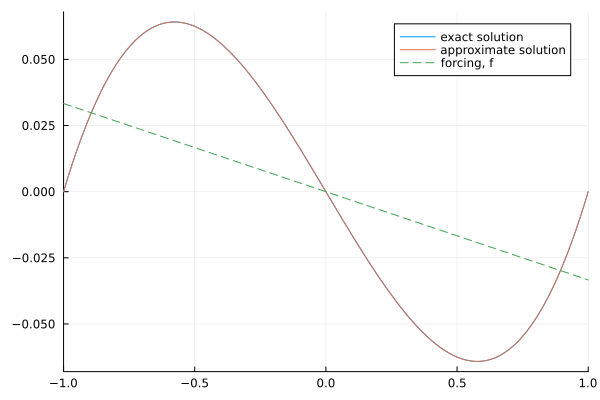

In [8]:
# data 
f = Polynomial([0,-1])

n = 5; 
X = ChebyshevNodes( n )[2:end-1]
A = zeros( n-1, n-1 )
b = zeros( n-1 )

# Store Lagrange polynomials (we don't need ℓ₀, ℓₙ)
ℓ = [ Lagrange( 1, n ) ];
for i = 2:(n-1)
    push!( ℓ, Lagrange( i, n ) )
end

# populate A, b (this is less efficient than it could be!)
for i = 1:(n-1) 
    b[i] = integrate( ℓ[i] * f, -1, 1 )
    for j=1:(n-1)
        A[i,j] = integrate( derivative( ℓ[i] ) * derivative( ℓ[j] ), -1, 1)
    end
end
c = A \ b
u = sum( c .* ℓ )

# In this particular case we know the exact solution U
U = x-> (1/6)*x*(x^2-1) 
println("error in max norm = ", maximum( x->abs(u(x)-U(x)), mesh ))

plot(U, -1, 1, label="exact solution")
plot!( u, label="approximate solution")
plot!( x->f(x)/30, linestyle=:dash, label="forcing, f" )

4. Experiment with the above code by changing the number of basis functions $n$. Is this choice of basis $\{\ell_j\}$ numerically stable?

<div class='alert alert-block alert-success'><b>Answer.</b> 


</div> 

## Hat functions 

Now fix $X = \{x_0< \dots< x_n\}$ to be the set of equispaced points on $[-1,1]$ with $x_0= -1$ and $x_n = 1$ and notice that $x_{i+1}-x_i = \frac{2}{n}$. Consider the *hat functions* $h_j$ defined as the functions that are linear in the intervals $[x_i, x_{i+1}]$ for all $i$ and such that $h_j(x_j) = 1$ and $h_j(x_i) = 0$ for all $i \not= j$. Here, we plot two of these functions:

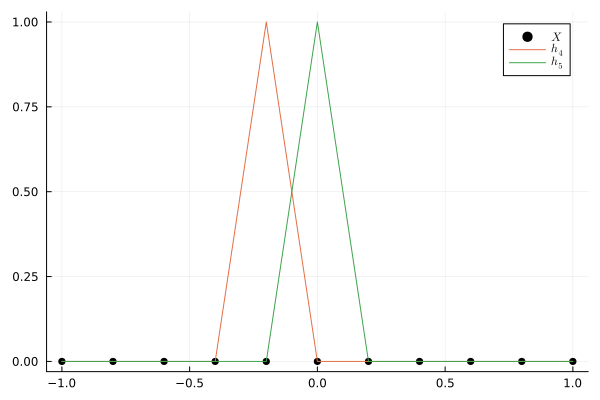

In [ ]:
n = 10;
X = -1:(2/n):1

scatter( X, zeros(n+1), label=L"X", color="black" )
plot!( [X[1],X[4], X[5], X[6], X[n+1]], [0, 0, 1, 0, 0], label=L"h_{4}")
plot!( [X[1], X[5], X[6], X[7], X[n+1]], [0, 0, 1, 0, 0], label=L"h_{5}")

5. Show that 

\begin{align}
    h_i(x) &= 
    \frac{n}{2}\begin{cases}
        x - x_{i-1} & \text{if } x \in [x_{i-1}, x_i]\\
        %
        x_{i+1} - x & \text{if } x \in [x_{i}, x_{i+1}]\\
        %
        0 &\text{otherwise}
    \end{cases}
\end{align}

<div class='alert alert-block alert-success'><b>Answer.</b> 


</div> 

We now use the basis set $\{h_j\}$ and expand $u(x) = \sum_{j=1}^{n-1} c_j h_j(x)$. Since $h_j(-1) = h_j(1) = 0$ for all $j=1,\dots,n-1$, $u$ satisfies the boundary condition. Again, we find the coeeficients $\{c_j\}$ by solving $A \bm c = \bm b$ where

\begin{align}
    A_{ij} &= \int_{-1}^1 h_i'(x) h_j'(x) \mathrm{d}x \\
    %
    b_{i} &= \int_{-1}^1 h_i(x)  f(x) \mathrm{d}x.
\end{align}

One may construct these integrals in the same way as we did before for the Lagrange polynomial basis but it turns out they have a very simple form:

6. Show that 

\begin{align}
    A &= -\frac{n}{2} 
    \begin{pmatrix}
        -2 & 1 & \\
        1 & -2 & 1 \\
        & 1 & -2 & \ddots \\
        & & \ddots &\ddots &  1 \\
        & & & 1 & -2
    \end{pmatrix}
\end{align}

Remark: $-A$ is the (scaled) discrete Laplacian.

<div class='alert alert-block alert-success'><b>Answer.</b> 


</div> 

7. Recall that we are considering $f(x) = -x$. Show that 

\begin{align}
    b_i = \int_{-1}^1 h_i(x) f(x) \mathrm{d}x = -\frac{2}{n} x_i.
\end{align}

<div class='alert alert-block alert-success'><b>Answer.</b> 


</div> 

We now implement $A \bm c = \bm b$ in order to solve the Poisson's equation with $f(x) = -x$. Here, our approximate solution is the piecewise linear function passing through the points plotted below:

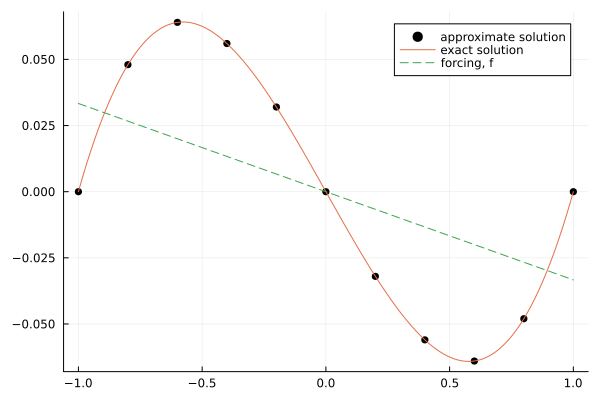

In [12]:
n = 10; 
X = (-1:(2/n):1)[2:end-1]
A = zeros( n-1, n-1 )
b = zeros( n-1 )

# populate A, b
for i = 1:(n-1) 
    b[i] = -2*X[i]
    A[i,i] = 1
    if (i<n-1)
        A[i,i+1] = -1/2
    end 
    if (i > 1)
        A[i, i-1] = -1/2
    end
end
c = (1/n^2) * (A \ b)

scatter( [-1; X; 1 ], [0; c; 0], label="approximate solution", color="black")
plot!( x->(1/6)*x*(x^2-1) , label="exact solution")
plot!( x->f(x)/30, linestyle=:dash, label="forcing, f" )

8. Experiment with the above code by changing the number of basis functions $n$. Is this choice of basis $\{h_j\}$ numerically stable?

<div class='alert alert-block alert-success'><b>Answer.</b> 


</div> 

**Bonus**: How would you impose $u(-1) = u_-$ and $u(+1) = u_+$ (with $u_{-} \not= 0$ or $u_+ \not= 0$) in this numerical scheme.

<div class='alert alert-block alert-success'><b>Answer.</b> 


</div> 